# Capstone Project
### Applied Data Science by IBM
### Michael Lynch
### April 12, 2020

## Table of contents
* [Introduction: Business Problem](#Introduction:-Business-Problem)
* [Data](#Data)
* [Methodology](#Methodology)
* [Analysis](#Analysis)
* [Results and Discussion](#Results-and-Discussion)
* [Conclusion](#Conclusion)

# Introduction: Business Problem

In this project we will analyze the spread of COVID-19 over time and space. We will also try to predict to increase in number of cases into the near future. This is important because it will help others see trends in the spread and will help myself learn python and complete the CourseEra Capstone course for IBM data science.

# Data

There is plentiful data for COVID-19 stats. Datasets can be found on GitHub and Kaggle.com. In this project we will utilze three datasets. The first dataset will be from covidtracking.com and it contains the data we will need to plot the rise in covid cases over time as well as predict the rise in cases into the near future. The second dataset is from John Hopkins' GitHub repository. This dataset contains covid-19 stats for each county in the USA which. The third dataset is from the NYTimes GitHub repository and is similar to the second dataset, except it doesn't come with the geospatial coordinates for each county. We will utilize a Python library called geocoder to get thsi information. Finally, we use the third dataset to make a heatmap with of covid cases that changes with each day so that we can visualize the spread of covid cases over time and space.

# Methodology

We will use the SVM machine learning algorithm to predict the increase in number of cases for each state in the USA. To find the best hyperparameters for the algorithm we will use a speacialized function in ski-kit-learn. We will see that the function did a good job in predicting the best hyperparameters by plotting the error with respect to one of the hyperparameters and see the error is lowest with the chosen hyperparameter. We will also use k-means clustering to find regions that are most concentrated with cases of COVID-19. We would expect regions high in population to be highest in cases of COVID-19.

# Analysis

### First, we import all nessesary libraries

In [119]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import folium
from sklearn.cluster import KMeans
import geocoder
import json
import time
import datetime

from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Our first dataset is downloaded from https://covidtracking.com/. Note that the dataset is updated each day. In this first analysis we will plot and predict the number of cases in a specific state, then will will use for loops to do the same for all states.

### Try to open the dataset in your current folder if you already have it saved. If it's not there, download and use the one from the website.

In [120]:
try:
    with open('daily.csv') as us_states_covid19_daily:
        df=pd.read_csv(us_states_covid19_daily)
except IOError: 
    url='https://covidtracking.com/api/v1/states/daily.csv'
    df=pd.read_csv(url)  

In [121]:
df.head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,20200412,AK,272.0,7766.0,NaN,NaN,31.0,NaN,NaN,NaN,...,31.0,8038.0,8038.0,8038.0,2,0.0,0.0,291.0,15.0,306.0
1,20200412,AL,3525.0,18058.0,NaN,NaN,437.0,NaN,189.0,NaN,...,437.0,21583.0,21583.0,21583.0,1,2.0,35.0,0.0,334.0,334.0
2,20200412,AR,1280.0,18442.0,NaN,74.0,130.0,NaN,43.0,30.0,...,130.0,19722.0,19722.0,19722.0,5,3.0,0.0,1090.0,54.0,1144.0
3,20200412,AS,0.0,3.0,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,5.0,3.0,3.0,60,0.0,0.0,0.0,0.0,0.0
4,20200412,AZ,3539.0,38570.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,42109.0,42109.0,42109.0,4,7.0,0.0,1433.0,146.0,1579.0


### Sort by state primarily and date secondarly

In [122]:
df.sort_values(['state','date'],inplace=True,ascending=(True,False))
df.head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,20200412,AK,272.0,7766.0,NaN,NaN,31.0,NaN,NaN,NaN,...,31.0,8038.0,8038.0,8038.0,2,0.0,0.0,291.0,15.0,306.0
56,20200411,AK,257.0,7475.0,NaN,NaN,31.0,NaN,NaN,NaN,...,31.0,7732.0,7732.0,7732.0,2,1.0,3.0,289.0,11.0,300.0
112,20200410,AK,246.0,7186.0,NaN,NaN,28.0,NaN,NaN,NaN,...,28.0,7432.0,7432.0,7432.0,2,0.0,1.0,198.0,11.0,209.0
168,20200409,AK,235.0,6988.0,NaN,NaN,27.0,NaN,NaN,NaN,...,27.0,7223.0,7223.0,7223.0,2,0.0,0.0,146.0,9.0,155.0
224,20200408,AK,226.0,6842.0,NaN,NaN,27.0,NaN,NaN,NaN,...,27.0,7068.0,7068.0,7068.0,2,1.0,4.0,142.0,13.0,155.0


### Make a list of all states. Note that this list actually contains territories to. We will make a revised list fo states later.

In [123]:
states=df['state'].unique()

### Delete Columns that don't have useful data that we care about

In [124]:
df=df.drop(['dateChecked','hash','pending','negative','deathIncrease','hospitalizedIncrease','negativeIncrease','positiveIncrease','totalTestResultsIncrease','fips','total','totalTestResults','posNeg'],axis=1)
df.head()

,date,state,positive,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized
0,20200412,AK,272.0,NaN,31.0,NaN,NaN,NaN,NaN,66.0,8.0,31.0
56,20200411,AK,257.0,NaN,31.0,NaN,NaN,NaN,NaN,63.0,8.0,31.0
112,20200410,AK,246.0,NaN,28.0,NaN,NaN,NaN,NaN,55.0,7.0,28.0
168,20200409,AK,235.0,NaN,27.0,NaN,NaN,NaN,NaN,49.0,7.0,27.0
224,20200408,AK,226.0,NaN,27.0,NaN,NaN,NaN,NaN,32.0,7.0,27.0


### The below cell splits the dataset into len(states) number of datasets, one for each state

In [125]:
df_dict={}
for i in range(len(states)):
    df_dict[states[i]]=[]
    for j in range(len(df)):
        if df['state'].iloc[j]==states[i]:
            df_dict[states[i]].append(df.iloc[j])

In [126]:
for i in range(len(df_dict)):
    df_dict[states[i]]=pd.DataFrame(df_dict[states[i]])

### Confirm that worked for a specific state

In [127]:
df_dict['MN']

,date,state,positive,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized
25,20200412,MN,1621.0,157.0,361.0,74.0,146.0,NaN,NaN,842.0,70.0,361.0
81,20200411,MN,1427.0,145.0,340.0,69.0,138.0,NaN,NaN,793.0,64.0,340.0
137,20200410,MN,1336.0,143.0,317.0,64.0,131.0,NaN,NaN,732.0,57.0,317.0
193,20200409,MN,1242.0,145.0,293.0,63.0,119.0,NaN,NaN,675.0,50.0,293.0
249,20200408,MN,1154.0,135.0,271.0,64.0,105.0,NaN,NaN,632.0,39.0,271.0
305,20200407,MN,1069.0,120.0,242.0,64.0,100.0,NaN,NaN,549.0,34.0,242.0
361,20200406,MN,986.0,115.0,223.0,57.0,90.0,NaN,NaN,470.0,30.0,223.0
417,20200405,MN,935.0,106.0,202.0,48.0,77.0,NaN,NaN,451.0,29.0,202.0
473,20200404,MN,865.0,95.0,180.0,42.0,69.0,NaN,NaN,440.0,24.0,180.0
529,20200403,MN,789.0,86.0,156.0,40.0,40.0,NaN,NaN,NaN,22.0,156.0


### Get a list of all the dates included in the dataset so that we can use it as our x-axis in some plots. Convert the dates to number of days since the first date. Also cast the data into a numpy array and reshape so that it is in the correct format for feeding into the SVM algorithm

In [133]:
dates_mn=df_dict['MN']['date']
dates_mn=pd.to_datetime(dates_mn, format='%Y%m%d')
day_num_mn=[i for i in range(len(dates_mn))]
day_num_mn=np.array(day_num_mn).reshape(-1,1)
#mn_dates=pd.Index(df_dict['MN']['date'].unique())

In [134]:
cases_mn=np.array(df_dict['MN']['positive'].tolist())
cases_mn=np.flip(cases_mn).reshape(-1,1)

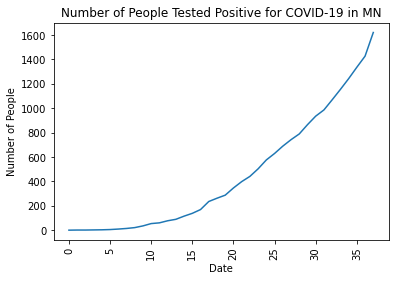

In [135]:
plt.plot(day_num_mn,cases_mn)
plt.title('Number of People Tested Positive for COVID-19 in MN')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.ylabel('Number of People')
plt.show()

### Define the number of days into the future we want to SVM algorithm to predict

In [138]:
days_in_future = 10
future_forcast_mn = np.array([i for i in range(len(dates_mn)+days_in_future)]).reshape(-1, 1)

### Split data into training and testing sets

In [139]:
X_train_mn, X_test_mn, y_train_mn, y_test_mn = train_test_split(day_num_mn, cases_mn, test_size=0.1, shuffle=False) 

### The following lines of code I altered from: https://www.kaggle.com/therealcyberlord/coronavirus-covid-19-visualization-prediction

In [140]:
# use this to find the optimal parameters for SVR
#c = [0.01, 0.1, 1]
#gamma = [0.01,0.015,0.02] #I had to alter this line because my system would crash with larger values
#epsilon = [0.01, 0.1, 1]
#shrinking = [True, False]
#degree = [3, 4, 5, 6, 7]
#
#svm_grid = {'C': c, 'gamma' : gamma, 'epsilon': epsilon, 'shrinking' : shrinking, 'degree': degree}
#
#svm = SVR(kernel='poly')
#svm_search = RandomizedSearchCV(svm, svm_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=30, verbose=1)
#svm_search.fit(X_train_mn, np.ravel(y_train_mn))
#
#svm_search.best_params_

#svm_confirmed_mn = svm_search.best_estimator_

### After finding the best parameters I kept them so I didn't always have to re-run teh above cell

In [143]:
#svm_confirmed_mn = svm_search.best_estimator_
svm_confirmed_mn = SVR(shrinking=False, kernel='poly',gamma=0.01, epsilon=0.1,degree=3, C=1)
svm_confirmed_mn.fit(X_train_mn, np.ravel(y_train_mn))
svm_pred_mn = svm_confirmed_mn.predict(future_forcast_mn)

### Get the Mean Absolute Error for degrees 1 thru 9 so that we can make a plot of that

In [144]:
MAE=[]
for i in range(1,10):
    svm_confirmed_degree_test = SVR(shrinking=False, kernel='poly',gamma=0.01, epsilon=0.1,degree=i, C=1)
    svm_confirmed_degree_test.fit(X_train_mn, np.ravel(y_train_mn))
    svm_pred_degree_test = svm_confirmed_degree_test.predict(future_forcast_mn)
    svm_test_pred_degree_test = svm_confirmed_degree_test.predict(X_test_mn)
    MAE.append(mean_absolute_error(svm_test_pred_degree_test, y_test_mn))


### Make a plot of degree vs. error to confirm that are hyperparameters are well chosen.

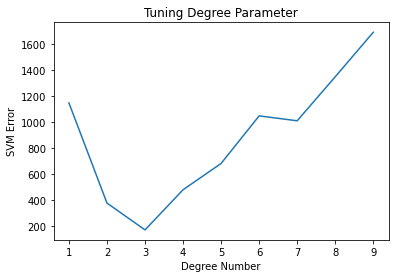

In [145]:
degree_num=list(range(1,10))
plt.plot(degree_num,MAE)
plt.title('Tuning Degree Parameter')
plt.ylabel('SVM Error')
plt.xlabel('Degree Number')
plt.show()

### Plot the predicted number of cases on top of the actual number of cases

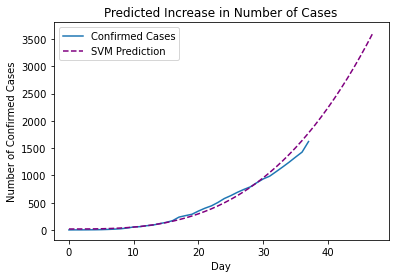

In [146]:
plt.plot(day_num_mn, cases_mn)
plt.plot(future_forcast_mn, svm_pred_mn, linestyle='dashed', color='purple')
plt.title('Predicted Increase in Number of Cases')
plt.legend(['Confirmed Cases','SVM Prediction'])
plt.xlabel('Day')
plt.ylabel('Number of Confirmed Cases')
plt.show()

### Get rid of the elements in the data that are not states. This will make our subplot below look better because we can shape it as 5x10, which we can do with 50 elements, but not 56.

In [147]:
not_states=['AS','GU','DC','PR','MP','VI']
for i in range(len(not_states)):
    del df_dict[not_states[i]]
key_list=list(df_dict.keys())

### Below we make a list of all states and repeat the process we did above on MN for all states using a lot of for loops.

In [148]:
states_list=[]
for i in range(len(states)):
    if states[i] not in not_states:
        states_list.append(states[i])

In [149]:
dates=[]
for i in range(len(states_list)):
    dates.append(pd.Index(df_dict[states_list[i]]['date'].unique()))
day_num=[]
for i in range(len(dates)):
    day_num.append([j for j in range(len(dates[i]))])
    day_num[i]=np.array(day_num[i]).reshape(-1,1)

In [150]:
day_num_length_list=[]
for i in range(len(day_num)):
    day_num_length_list.append(len(day_num[i]))
    
min_day_num=min(day_num_length_list)

In [151]:
cases=[]
for i in range(len(df_dict)):
    cases.append(np.array(df_dict[states_list[i]]['positive'].tolist()))
    cases[i]=np.flip(cases[i]).reshape(-1,1)

In [152]:
#cases_us=[]
#for day in list(df['date'].unique()):
#    cases_us.append(df[df['date']==day]['positive'].sum())
#cases_us=np.array(cases_us)
#cases_us=np.flip(cases_us).reshape(-1,1)


In [153]:
days_in_future=10
future_forcast=[]
for i in range(len(dates)):
    future_forcast.append(np.array([j for j in range(len(dates[i])+days_in_future)]).reshape(-1, 1))

In [154]:
svm_confirmed = svm_confirmed_mn

X_train=[0 for i in range(len(cases))]
X_test=[0 for i in range(len(cases))]
y_train=[0 for i in range(len(cases))]
y_test=[0 for i in range(len(cases))]
for i in range(len(cases)):
    X_train[i], X_test[i], y_train[i], y_test[i] = train_test_split(day_num[i], cases[i], test_size=0.1, shuffle=False)

In [155]:
svm_pred=[0 for i in range(len(cases))]
for i in range(len(cases)):
        svm_confirmed.fit(X_train[i], np.ravel(y_train[i]))
        svm_pred[i] = svm_confirmed.predict(future_forcast[i])

### Make a plot of the number of cases vs time for each of the fifty states of the US.

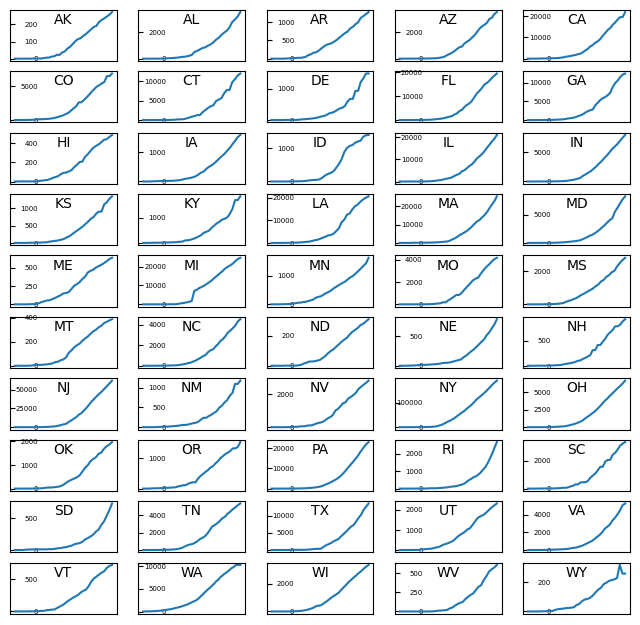

In [157]:
plt.figure(figsize=(8,8),dpi=100)
for i in range(50):
    plt.subplot(10,5,i+1)    
    plt.plot(day_num[i],cases[i])
    plt.title(key_list[i],loc='center',pad=-10,fontsize=10)
    plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
    plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected  
    direction='in',
    labelsize=5,
    pad=-20)

### Make a plot of the number of predicted cases for each state on top of the actual data for each state

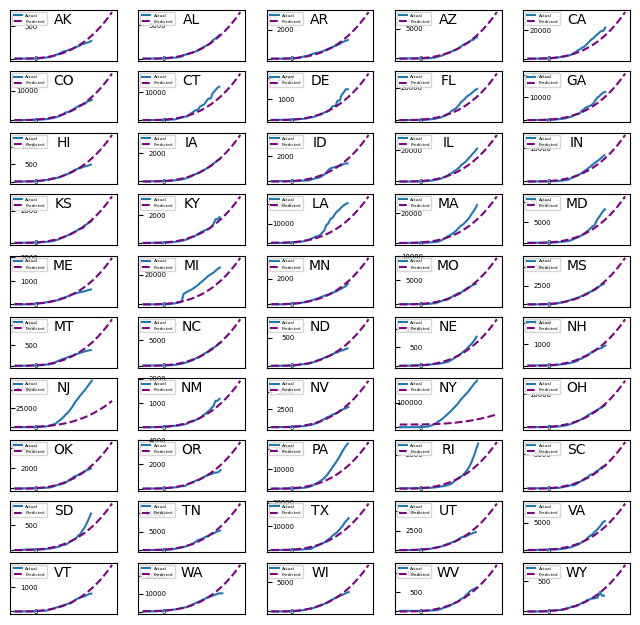

In [158]:
plt.figure(figsize=(8,8),dpi=100)
for i in range(50):
    plt.subplot(10,5,i+1)    
    plt.plot(day_num[i],cases[i])
    plt.plot(future_forcast[i], svm_pred[i], linestyle='dashed', color='purple')
    plt.title(states_list[i],loc='center',pad=-10,fontsize=10)
    plt.legend(['Actual','Predicted'],fontsize=3)
    plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
    plt.tick_params(
    axis='y',         
    which='both',      
    direction='in',
    labelsize=5,
    pad=-20)

### Now let's make dataframe with only the cumulative data from the most recent date of each state. That way we can see how the virus is spread over space.

In [165]:
df_cum=df.sort_index()
df_cum.head()

,date,state,positive,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized
0,20200412,AK,272.0,NaN,31.0,NaN,NaN,NaN,NaN,66.0,8.0,31.0
1,20200412,AL,3525.0,NaN,437.0,NaN,189.0,NaN,119.0,NaN,93.0,437.0
2,20200412,AR,1280.0,74.0,130.0,NaN,43.0,30.0,39.0,367.0,27.0,130.0
3,20200412,AS,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20200412,AZ,3539.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,115.0,NaN


### Retrieve only the first 56 rows because that is today's date and drop all unnessary columns

In [166]:
df_cum=df_cum.iloc[0:56]

In [167]:
#get rid of rows that are us territories, not states: AS, GU, DC, PR, MP, VI
drop_ind=[3,8,12,27,42,50]
df_cum.drop(index=drop_ind,inplace=True)

In [168]:
df_cum.reset_index(drop=True,inplace=True)
#df_cum['positive'].astype('int',inplace=True)

### I had to create the following list with the states organized alphabetically by their two letter designation

In [169]:
state_names=['Alaska','Alabama','Arkansas','Arizona','California','Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Iowa', 'Indiana','Idaho', 'Illinois', 'Kansas', 'Kentucky', 'Louisiana', 'Massachusetts', 'Maryland','Maine','Michigan', 'Minnesota', 'Missouri','Mississippi', 'Montana', 'North Carolina', 'North Dakota','Nebraska', 'New Hampshire','New Jersey','New Mexico','Nevada','New York', 'Ohio','Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina','South Dakota', 'Tennessee', 'Texas', 'Utah','Virginia','Vermont', 'Washington', 'Wisconsin','West Virginia', 'Wyoming']

In [170]:
df_cum['State_Names']=pd.DataFrame(state_names)

In [171]:
df_cum=df_cum[['date','state','State_Names','positive','hospitalizedCurrently','inIcuCurrently','inIcuCumulative','onVentilatorCurrently','onVentilatorCumulative','recovered','death','hospitalized']]

### Let's view the whole dataset to confirm the two letter designation matches with the full state name

In [172]:
df_cum

,date,state,State_Names,positive,hospitalizedCurrently,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized
0,20200412,AK,Alaska,272.0,NaN,NaN,NaN,NaN,NaN,66.0,8.0,31.0
1,20200412,AL,Alabama,3525.0,NaN,NaN,189.0,NaN,119.0,NaN,93.0,437.0
2,20200412,AR,Arkansas,1280.0,74.0,NaN,43.0,30.0,39.0,367.0,27.0,130.0
3,20200412,AZ,Arizona,3539.0,NaN,NaN,NaN,NaN,NaN,NaN,115.0,NaN
4,20200412,CA,California,21794.0,5234.0,1539.0,NaN,NaN,NaN,NaN,651.0,NaN
5,20200412,CO,Colorado,6893.0,NaN,NaN,NaN,NaN,NaN,NaN,274.0,1376.0
6,20200412,CT,Connecticut,12035.0,1654.0,NaN,NaN,NaN,NaN,NaN,554.0,NaN
7,20200412,DE,Delaware,1479.0,190.0,NaN,NaN,NaN,NaN,191.0,33.0,NaN
8,20200412,FL,Florida,19355.0,NaN,NaN,NaN,NaN,NaN,NaN,465.0,2772.0
9,20200412,GA,Georgia,12452.0,NaN,NaN,NaN,NaN,NaN,NaN,433.0,2505.0


### Import a json file containing the state boundaries so we can use it for a choropleth map. If it's not in your current working directory download it from GitHub using the wget library. State boundaries json downloaded from https://github.com/PublicaMundi/MappingAPI/blob/master/data/geojson/us-states.json?short_path=1c1ebe5

In [173]:
try:
    with open('us-states.json') as jsonfile:
        json_path=jsonfile.name
except IOError:
    import wget
    us_states_json_url='https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json'
    us_states_json=wget.download(us_states_json_url)
    json_path=us_states_json

In [174]:
us_map = folium.Map(location=[37,-96], zoom_start=4)

### We bin the data so that the colors on the chororpleth map are nicely spread

In [175]:
bins = list(df_cum['positive'].quantile([0, 0.25, 0.5, 0.75, 1]))
bins

[261.0, 1294.25, 3077.5, 9724.25, 188694.0]

### Make a choropleth map of the number of cases in each state

In [176]:
folium.Choropleth(
    geo_data=json_path,
    data=df_cum,
    columns=['State_Names', 'positive'],
    key_on='feature.properties.name',
    fill_color='YlGn', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='COVID-19',
    bins=bins,
    reset=True
).add_to(us_map)


# display map
us_map

## Dataset 2: Next we will import a database of all COVID-19 cases in each county of the US so that we can use it to to run k-means clustering to map the areas of the country that are dense in COVID-19 cases. Dataset from John Hopkins GitHub Repository: https://github.com/CSSEGISandData/COVID-19

### Similar code to what we did above with importing the first dataset

In [177]:
try:
    with open('time_series_covid19_confirmed_US.csv') as timeseries:
        df_counties=pd.read_csv(timeseries)
except IOError:
    counties_url='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
    df_counties=pd.read_csv(counties_url)

In [178]:
df_counties.head(10)

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.271000,-170.132000,...,0,0,0,0,0,0,0,0,0,0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.444300,144.793700,...,82,84,93,112,113,121,121,128,130,133
2,580,MP,MNP,580,69.0,NaN,Northern Mariana Islands,US,15.097900,145.673900,...,6,6,6,6,6,6,6,6,6,6
3,630,PR,PRI,630,72.0,NaN,Puerto Rico,US,18.220800,-66.590100,...,316,316,452,475,513,573,620,683,725,788
4,850,VI,VIR,850,78.0,NaN,Virgin Islands,US,18.335800,-64.896300,...,30,37,40,42,43,43,45,45,50,51
5,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,10,12,12,12,12,12,12,15,17,19
6,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,24,28,29,29,38,42,44,56,59,66
7,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,0,1,2,2,2,3,3,4,9,9
8,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,4,4,4,5,7,8,9,9,11,13
9,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,6,9,10,10,10,10,10,11,12,12


### Delete the columns we don't care about

In [179]:
df_counties=df_counties.drop(['UID','iso2','iso3','code3','FIPS'],axis=1)
df_counties.head(10)

,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,...,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20
0,NaN,American Samoa,US,-14.271000,-170.132000,"American Samoa, US",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NaN,Guam,US,13.444300,144.793700,"Guam, US",0,0,0,0,...,82,84,93,112,113,121,121,128,130,133
2,NaN,Northern Mariana Islands,US,15.097900,145.673900,"Northern Mariana Islands, US",0,0,0,0,...,6,6,6,6,6,6,6,6,6,6
3,NaN,Puerto Rico,US,18.220800,-66.590100,"Puerto Rico, US",0,0,0,0,...,316,316,452,475,513,573,620,683,725,788
4,NaN,Virgin Islands,US,18.335800,-64.896300,"Virgin Islands, US",0,0,0,0,...,30,37,40,42,43,43,45,45,50,51
5,Autauga,Alabama,US,32.539527,-86.644082,"Autauga, Alabama, US",0,0,0,0,...,10,12,12,12,12,12,12,15,17,19
6,Baldwin,Alabama,US,30.727750,-87.722071,"Baldwin, Alabama, US",0,0,0,0,...,24,28,29,29,38,42,44,56,59,66
7,Barbour,Alabama,US,31.868263,-85.387129,"Barbour, Alabama, US",0,0,0,0,...,0,1,2,2,2,3,3,4,9,9
8,Bibb,Alabama,US,32.996421,-87.125115,"Bibb, Alabama, US",0,0,0,0,...,4,4,4,5,7,8,9,9,11,13
9,Blount,Alabama,US,33.982109,-86.567906,"Blount, Alabama, US",0,0,0,0,...,6,9,10,10,10,10,10,11,12,12


### Make a dataframe with just latitude, longitude, and number of cases

In [181]:
most_recent_day='4/11/20'
df_counties_small=df_counties[['Lat','Long_',most_recent_day]]
df_counties_small.head()

,Lat,Long_,4/11/20
0,-14.2710,-170.1320,0
1,13.4443,144.7937,133
2,15.0979,145.6739,6
3,18.2208,-66.5901,788
4,18.3358,-64.8963,51


### Setup our kmean parameters and run kmeans to get the centers where cases are the most dense

In [182]:
kclusters=100
kmeans=KMeans(n_clusters=kclusters,random_state=0).fit(df_counties_small)
centers=kmeans.cluster_centers_

In [183]:
lats=pd.Series(centers[:,0])
longs=pd.Series(centers[:,1])
weights=centers[:,2]

### Now we make the map of the cluster centers

In [184]:
cluster_map=folium.Map(location=[37,-96], zoom_start=4)
for lat,long in zip(lats,longs):
    folium.CircleMarker(
            [lat,long],
            radius=5).add_to(cluster_map)

cluster_map

### The clusters seemed to be centered around areas that have large populations, which makes sense.

##  Dataset 3: Let's use another dataset which doesn't explictly have the latitudes and longitudes for each county. We can use geocoding to get the latitude and longitude for each county if we aren't explictly given it. The dataset we will use is found in the NY Times GitHub Repository here: https://github.com/nytimes/covid-19-data

### Import the data using similar code we did for the first and second datasets

In [185]:
try:
    with open('us-counties.csv') as uscounties:
        df_counties2=pd.read_csv(uscounties)
except IOError:
    counties2_url='https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'
    df_counties2=pd.read_csv(counties2_url)


In [186]:
df_counties2.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0
1,2020-01-22,Snohomish,Washington,53061.0,1,0
2,2020-01-23,Snohomish,Washington,53061.0,1,0
3,2020-01-24,Cook,Illinois,17031.0,1,0
4,2020-01-24,Snohomish,Washington,53061.0,1,0


### We make a column of the combined name of county and state. If the county name is unknown this causes problems with the geocoding API. So that we don't get that problem we don't include the county name there.

In [187]:
for i in range(len(df_counties2)):
    if df_counties2['county'][i]!='Unknown':
        df_counties2.at[i,'county, state']=df_counties2['county'][i]+', '+df_counties2['state'][i]
    elif df_counties2['county'][i]=='Unknown':
        df_counties2.at[i,'county, state']=df_counties2['state'][i]
df_counties2.tail()

,date,county,state,fips,cases,deaths,"county, state"
51164,2020-04-11,Sublette,Wyoming,56035.0,1,0,"Sublette, Wyoming"
51165,2020-04-11,Sweetwater,Wyoming,56037.0,7,0,"Sweetwater, Wyoming"
51166,2020-04-11,Teton,Wyoming,56039.0,53,0,"Teton, Wyoming"
51167,2020-04-11,Uinta,Wyoming,56041.0,4,0,"Uinta, Wyoming"
51168,2020-04-11,Washakie,Wyoming,56043.0,4,0,"Washakie, Wyoming"


In [188]:
county_state_list=list(df_counties2['county, state'].unique())
county_state_list
len(county_state_list)

2693

## **The next few cells take a long time because they send many calls to the API. Be aware of the API usage restrictions, quotas, and limits. To bypass this I split the API calls up into 3 chunks and ran each chunk separatly. I saved the data after running each chunk. If you have problems running this part you can just download the file from my github, but I can't promise it will be up to date: https://github.com/mjlynch91/Coursera_Capstone/blob/master/county_lat_lng.txt

### You really have to be careful which cells you run the in next few cells depending on whether you are downloading the data, or just loading the data from you local disk.

In [191]:
API_KEY='Pur Your API Key Here'
#g_total=[]
#for name in county_state_list[0:1000]:
#    g_current = geocoder.google(name,key=API_KEY)
#    g_total.append(g_current)

In [66]:
len(g_total)

2573

In [58]:
#for name in county_state_list[1000:2000]:
#    g_current = geocoder.google(name,key=API_KEY)
#    g_total.append(g_current)

In [192]:
for name in county_state_list[2573:len(county_state_list)]:
    g_current = geocoder.google(name,key=API_KEY)
    g_total.append(g_current)

### So that we don't have to run the above cell everytime, I've saved the data to a file

In [193]:
g_dict={}
g_dict['counties']=[]
for i in range(len(g_total)):
    if type(g_total[i])==type(g_current):
        g_dict['counties'].append(g_total[i].json)
    else:
        g_dict['counties'].append(g_total[i])

In [194]:
with open('county_lat_lng.txt', 'w') as outfile:
    json.dump(g_dict, outfile)

In [195]:
for i in range(len(g_total)):
    if type(g_total[i])!=dict:
        print(i,type(g_total[i]))

2661 <class 'geocoder.google.GoogleQuery'>
2662 <class 'geocoder.google.GoogleQuery'>
2663 <class 'geocoder.google.GoogleQuery'>
2664 <class 'geocoder.google.GoogleQuery'>
2665 <class 'geocoder.google.GoogleQuery'>
2666 <class 'geocoder.google.GoogleQuery'>
2667 <class 'geocoder.google.GoogleQuery'>
2668 <class 'geocoder.google.GoogleQuery'>
2669 <class 'geocoder.google.GoogleQuery'>
2670 <class 'geocoder.google.GoogleQuery'>
2671 <class 'geocoder.google.GoogleQuery'>
2672 <class 'geocoder.google.GoogleQuery'>
2673 <class 'geocoder.google.GoogleQuery'>
2674 <class 'geocoder.google.GoogleQuery'>
2675 <class 'geocoder.google.GoogleQuery'>
2676 <class 'geocoder.google.GoogleQuery'>
2677 <class 'geocoder.google.GoogleQuery'>
2678 <class 'geocoder.google.GoogleQuery'>
2679 <class 'geocoder.google.GoogleQuery'>
2680 <class 'geocoder.google.GoogleQuery'>
2681 <class 'geocoder.google.GoogleQuery'>
2682 <class 'geocoder.google.GoogleQuery'>
2683 <class 'geocoder.google.GoogleQuery'>
2684 <class

### Read the file from your local disk if you already have it.

In [189]:
with open('county_lat_lng.txt') as json_file:
    g_dict = json.load(json_file)

In [190]:
g_total=g_dict['counties']

### Now that we have the coordinates, we put them into the dataframe

In [196]:
# g_current = geocoder.google('Minneasota',key=API_KEY)
lat_long=[]
for i in range(len(g_total)):
    if type(g_total[i])==type(g_current):
        lat_long.append([g_total[i].lat, g_total[i].lng])
    else:
        lat_long.append([g_total[i]['lat'], g_total[i]['lng']])
    

In [197]:
#changing lat_long to a numpy array since it's easier to get columns and rows out
lat_long=np.array([[i[0] for i in lat_long],[i[1] for i in lat_long]])

In [198]:
county_dict={}
for i in range(len(county_state_list)):
    county_dict.update({county_state_list[i]:tuple(lat_long[:,i])})

In [199]:
lat_series=[]
long_series=[]
for i in range(len(df_counties2)):
    lat_series.append(county_dict[df_counties2['county, state'][i]][0])
    long_series.append(county_dict[df_counties2['county, state'][i]][1])

In [200]:
df_counties2['latitude']=lat_series
df_counties2['longitude']=long_series
df_counties2.tail()

,date,county,state,fips,cases,deaths,"county, state",latitude,longitude
51164,2020-04-11,Sublette,Wyoming,56035.0,1,0,"Sublette, Wyoming",42.813872,-109.759168
51165,2020-04-11,Sweetwater,Wyoming,56037.0,7,0,"Sweetwater, Wyoming",41.851940,-109.188005
51166,2020-04-11,Teton,Wyoming,56039.0,53,0,"Teton, Wyoming",43.853632,-110.631449
51167,2020-04-11,Uinta,Wyoming,56041.0,4,0,"Uinta, Wyoming",41.210740,-110.616892
51168,2020-04-11,Washakie,Wyoming,56043.0,4,0,"Washakie, Wyoming",43.006346,-108.882346


### Now we map a heatmap of all the cases over the entire US. This is a different method to show which areas are most dense in virus cases

In [204]:
most_recent_day2='2020-04-11'
df_counties_curr=df_counties2[df_counties2['date']==most_recent_day2]
df_counties_curr.head()
heatmap_list=df_counties_curr[['latitude','longitude','cases']].values.tolist()

In [205]:
heatmap_list

[[32.5791817, -86.49965460000001, 19.0],
 [30.6010744, -87.77633329999999, 66.0],
 [31.8172896, -85.35496499999999, 10.0],
 [32.9562798, -87.14228949999999, 13.0],
 [34.0145152, -86.49965460000001, 12.0],
 [32.0573536, -85.7256372, 4.0],
 [32.0895908, -88.2219652, 6.0],
 [33.7701576, -85.80766, 57.0],
 [32.9028048, -85.35496499999999, 184.0],
 [34.7570342, -87.9728143, 7.0],
 [32.944392, -86.6611083, 30.0],
 [32.0716631, -88.24611829999999, 9.0],
 [31.7002461, -87.77633329999999, 15.0],
 [33.7026013, -86.5997096, 12.0],
 [33.6261707, -85.52002399999999, 12.0],
 [31.4751172, -86.0121573, 20.0],
 [34.7117567, -87.89424509999999, 8.0],
 [31.501571, -86.9824288, 3.0],
 [32.8897772, -86.2196937, 11.0],
 [31.3066438, -86.49965460000001, 11.0],
 [31.6671872, -86.3376761, 2.0],
 [34.1748208, -86.8436124, 31.0],
 [31.4645298, -85.684578, 6.0],
 [32.2332138, -87.14228949999999, 10.0],
 [34.5211397, -85.684578, 21.0],
 [32.5387448, -86.3149712, 30.0],
 [31.1394734, -87.14228949999999, 8.0],
 [34.

In [203]:
from folium.plugins import HeatMap
base_map=folium.Map(location=[37,-96], zoom_start=4)
HeatMap(data=heatmap_list,radius=10).add_to(base_map)
base_map    

### Finally we visualize the spread of COVID-19 over both TIME AND SPACE. Let's extend our heatmap list in the time dimension so we can watch it's evolution

In [206]:
heatmap_list_time=[]
for date in df_counties2['date'].unique():
    df_counties_curr=df_counties2[df_counties2['date']==date]
    heatmap_list_time.append(df_counties_curr[['latitude','longitude','cases']].values.tolist())

In [207]:
from folium.plugins import HeatMapWithTime
base_map=folium.Map(location=[37,-96], zoom_start=4)
HeatMapWithTime(data=heatmap_list_time, radius=10,auto_play=True).add_to(base_map)
base_map

# Results and Discussion

It is clear from the above analysis that the number of coronavirus cases will continue to increase in every state of the US. It is also clear the areas with larger populations have a larger number of cases, which is what would be expected, unless drastic quarantine or stay-at-home orders were issued in those areas.

# Conclusion

Using Python and various libraries for Python I have analyzed and shown visualization of the spread of coronavirus over the US in both space and time. It is clear from the above analysis that the situation is serious, and the spread isn’t stopping anytime soon. 